# Dynawo simulation - Nordic case

The Nordic test system is a variation of the so-called Nordic 32-bus system, which was created by the CIGRE Task Force 38-02-08 in 1995 to illustrate the voltage collapse in Sweden that happened in the year 1983. 
The test case consists of four areas: an equivalent simplified network that has the biggest generators and therefore serves usually as the system reference, the northern region with few loads and more generation, a central area with more load than generation and a southern region loosely connected to the rest of the system.
One important characteristic of the system is the high power transfer from the North to the Central area. This characteristic is what ultimately results in long-term voltage collapse if the power transfer capability is affected, e.g. by losing one of the transmission lines that connect both areas.
The system comprises 20 generators (nineteen generators and one synchronous condenser) that are hydro and thermal generations. All loads are connected to 20 kV buses and controlled by Load Tap Changers (LTC).

## 1 - Dynawo install

In [ ]:
!curl -L $(curl -s -L -X GET https://api.github.com/repos/dynawo/dynawo/releases/latest | grep "Dynawo_Linux" | grep url | cut -d '"' -f 4) -o Dynawo_Linux_latest.zip
!unzip Dynawo_Linux_latest.zip > /dev/null 2>&1
!./dynawo/dynawo.sh help

## 2 - Powsybl install

In [ ]:
pip install pypowsybl

In [ ]:
!mkdir /home/USER/.itools/
!cp /home/USER/dynawo/nordic case/config.yml /home/USER/.itools/
!cat /home/USER/.itools/config.yml

## 3 - Base case

In [1]:
import pypowsybl as pp
import pypowsybl.dynamic as dyn
import pandas as pd
import matplotlib.pyplot as plt
import os.path

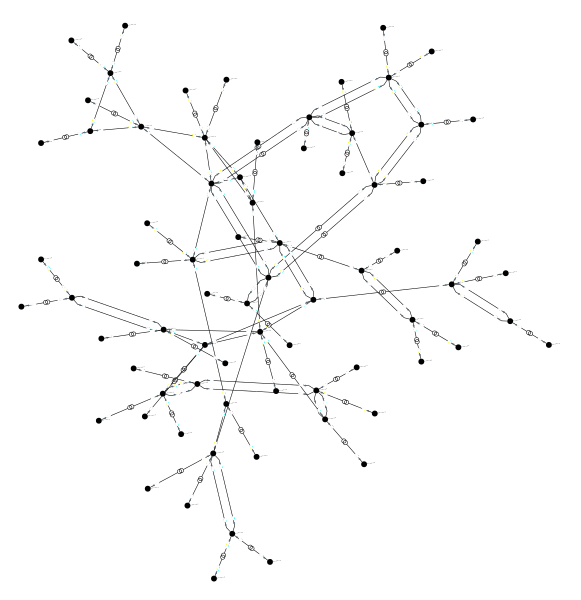

In [2]:
# Load initial situation
network = pp.network.load('Nordic.xiidm')
network.clone_variant('InitialState', 'BaseCase')
network.set_working_variant('BaseCase')
network.get_network_area_diagram()

Add generators dynamic models : 
Out of the total of twenty generators, the Equivalent and the North networks have twelve hydro generators that are modeled by salient-pole machines (GeneratorSynchronousThreeWindingsGoverNordicVRNordic). The two biggest generators belong to the Equivalent grid while the North area has ten generators. On the other hand, there are seven thermal generators modeled by round-rotor machines (GeneratorSynchronousFourWindingsPmConstVRNordic), two of them belong to the small South region, and the remaining five to the Central one that also has a synchronous condenser that is modeled as a salient-pole machine (GeneratorSynchronousThreeWindingsPmConstVRNordic).

In [3]:
model_mapping = dyn.ModelMapping()
generator_mapping_df = pd.DataFrame.from_records(
    index='static_id',
    columns=['static_id', 'parameter_set_id', 'model_name'],
    data=[('g01', 'g01', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g02', 'g02', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g03', 'g03', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g04', 'g04', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g05', 'g05', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g06', 'g06', 'GeneratorSynchronousFourWindingsPmConstVRNordic'),
         ('g07', 'g07', 'GeneratorSynchronousFourWindingsPmConstVRNordic'),
         ('g08', 'g08', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g09', 'g09', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g10', 'g10', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g11', 'g11', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g12', 'g12', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g13', 'g13', 'GeneratorSynchronousThreeWindingsPmConstVRNordic'),
         ('g14', 'g14', 'GeneratorSynchronousFourWindingsPmConstVRNordic'),
         ('g15', 'g15', 'GeneratorSynchronousFourWindingsPmConstVRNordic'),
         ('g16', 'g16', 'GeneratorSynchronousFourWindingsPmConstVRNordic'),
         ('g17', 'g17', 'GeneratorSynchronousFourWindingsPmConstVRNordic'),
         ('g18', 'g18', 'GeneratorSynchronousFourWindingsPmConstVRNordic'),
         ('g19', 'g19', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic'),
         ('g20', 'g20', 'GeneratorSynchronousThreeWindingsGoverNordicVRNordic')])
model_mapping.add_synchronous_generator(generator_mapping_df)

Add node fault and disconnect line event:
The scenario consists of a three-phase fault at bus 4032 with a subsequent opening of the line 4032-4044 without further re-connection.

In [4]:
event_mapping = dyn.EventMapping()
event_mapping.add_node_fault(static_id='4032_401', start_time=1, fault_time=0.1, r_pu=0.025, x_pu=0.025)
event_mapping.add_disconnection(static_id='L4032-4044', start_time=1.1)

Request curves output

In [5]:
variables_mapping = dyn.OutputVariableMapping()
variables_mapping.add_standard_model_curves('1042_131', 'U_value')

Run simulation

In [6]:
sim = dyn.Simulation()
res = sim.run(network, model_mapping, event_mapping, variables_mapping, 0, 175)

Display curve 

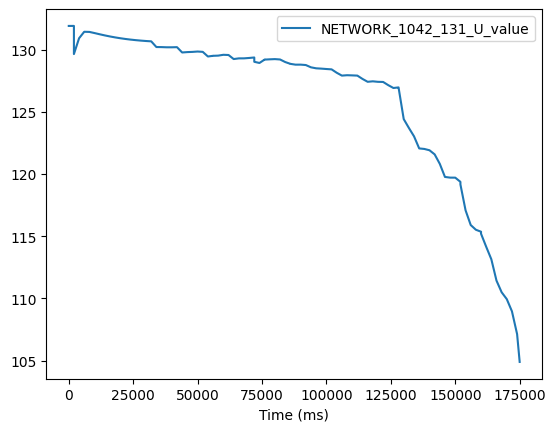

In [9]:
c = res.curves().plot()
c.set_xlabel('Time (ms)')
plt.show()

Comment on the result:
The line 4032-4044 is tripped 0.1 s later. The system is short-term stable and it settles to a new equilibrium in 30 s. At around 35 s, the LTCs start acting attempting to restore the distribution voltage and hence the load consumption. The action of the LTC forces the generators to increase their reactive power injection and therefore their field current. Due to the actions of the LTCs, the OELs of some generators limit the field current. This leads to the voltage collapse depicted in the figure.

## 4 - Second simulation with tap changer blocking automation system

Add a tap changer blocking automaton that will block the transformer when the monitored voltage is below a certain threshold

In [10]:
tcb_df = pd.DataFrame.from_records(
    index='dynamic_model_id',
    columns=['dynamic_model_id', 'parameter_set_id'],
    data=[('TCB', 'TCB')])
# Transformers
tfo_ids = ['Tr11-1011', 'Tr12-1012', 'Tr13-1013', 'Tr22-1022', 'Tr1-1041', 'Tr2-1042', 'Tr3-1043', 'Tr4-1044', 'Tr5-1045', 'Tr31-2031',
        'Tr32-2032', 'Tr41-4041', 'Tr42-4042', 'Tr43-4043', 'Tr46-4046', 'Tr47-4047', 'Tr51-4051', 'Tr61-4061', 'Tr62-4062', 'Tr63-4063'
        'Tr71-4071', 'Tr72-4072']
tfo_df = pd.DataFrame.from_records(
    index='dynamic_model_id',
    columns=['dynamic_model_id', 'transformer_id'],
    data={'dynamic_model_id': ['TCB' for tfo in tfo_ids],
        'transformer_id': tfo_ids})
# Measurement point
measurement1_df = pd.DataFrame.from_records(
    index='dynamic_model_id',
    columns=['dynamic_model_id', 'measurement_point_id'],
    data=[('TCB', '1042_131')])
model_mapping.add_tap_changer_blocking_automation_system(df=tcb_df,
                                                         tfo_df=tfo_df,
                                                         mp1_df=measurement1_df)

Run second simulation

In [11]:
network.clone_variant('InitialState', 'TCBCase')
network.set_working_variant('TCBCase')
res = sim.run(network, model_mapping, event_mapping, variables_mapping, 0, 300)

Display curve

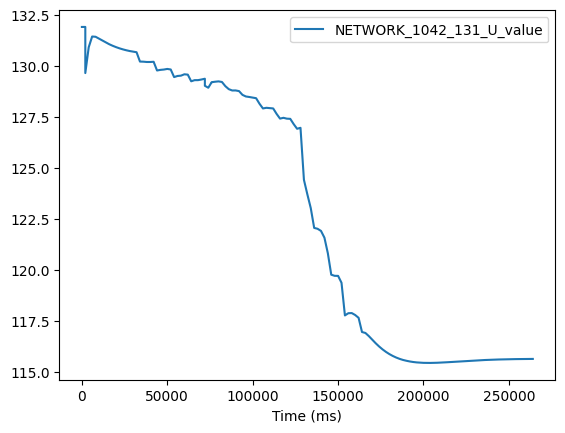

In [12]:
c = res.curves().plot()
c.set_xlabel('Time (ms)')
plt.show()

Comment on the result :
When adding a Tap Changer Blocking Automaton, that blocks the LTCs when the voltage at bus 1042 is below 120kV, the voltage collapse is avoided, as shown in the figure.